Step 1: Preprocessing Data
Before cleaning:
Shape of data: (668, 1)
Missing values: Tweet    0
dtype: int64
Duplicated rows: 61
After cleaning:
Shape of data: (607, 1)
Missing values: Tweet    0
dtype: int64
Duplicated rows: 0


Device set to use mps:0


Sentiment analysis completed.
Text cleaning completed.
Step 2: Detecting Bias
Detecting gender bias in pronoun usage...
Bias detected in pronoun usage:
{'male': np.float64(0.0), 'female': np.float64(0.0), 'neutral': np.float64(0.0)}
Detecting racial bias related to Kosovo and Serbia...
Bias detected in racial term usage:
{'kosovo': np.float64(0.5024711696869851), 'serbia': np.float64(0.45634266886326197), 'conflict-related': np.float64(0.054365733113673806)}
Detecting other biases (e.g., political, ideological)...
Detected political/ideological bias score: 0.0
Step 3: Quantifying Bias
Counting conflict-related terms in tweets...
Counting peace-related terms in tweets...
Quantified bias balance:
   conflict_count  peace_count  bias_balance
0               0            0      0.741071
1               0            0      0.741071
2               0            0      0.741071
3               1            0      0.741071
4               0            0      0.741071
Step 4: Mitigating Bias
Mi

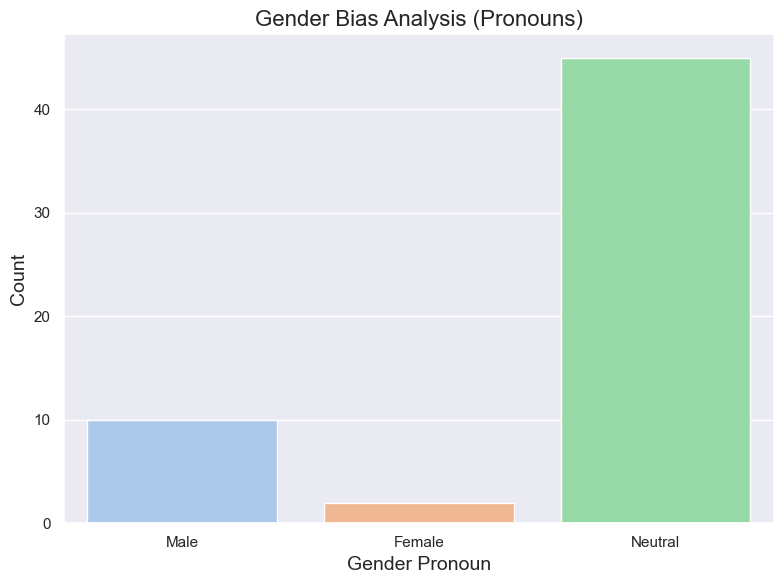

Visualizing racial term usage frequency...


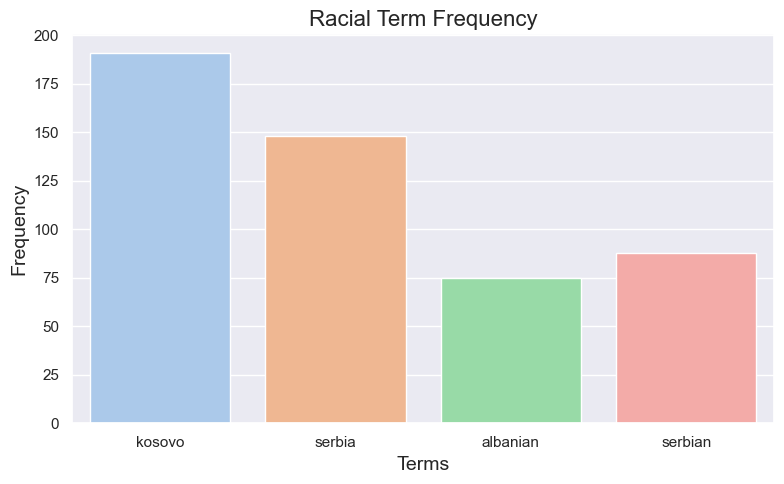

Visualizing conflict vs peace balance distribution...


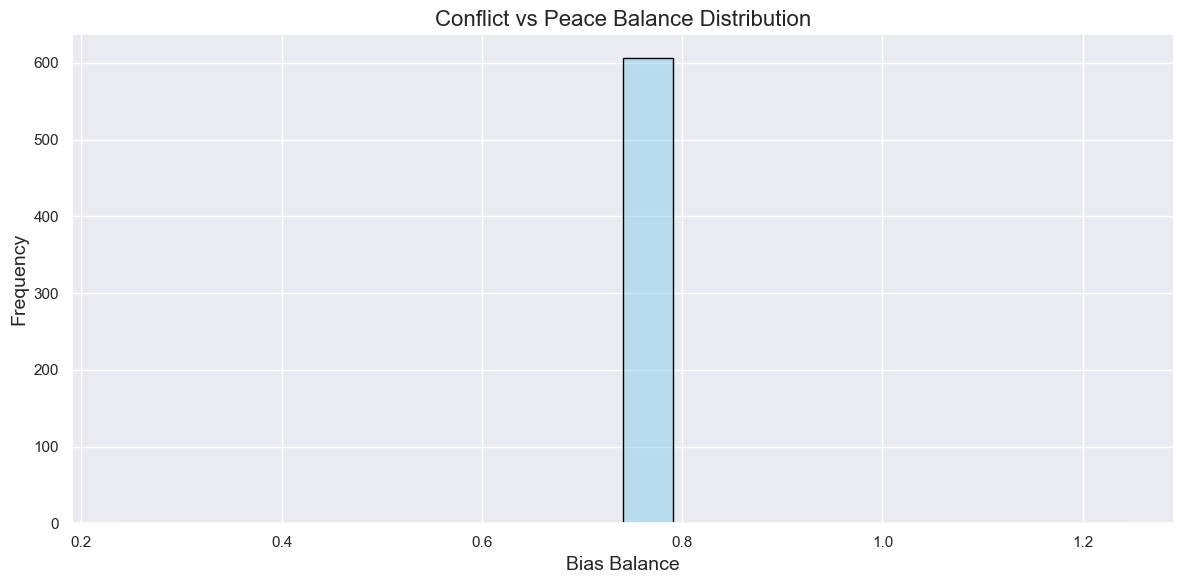

Visualizing sentiment distribution...


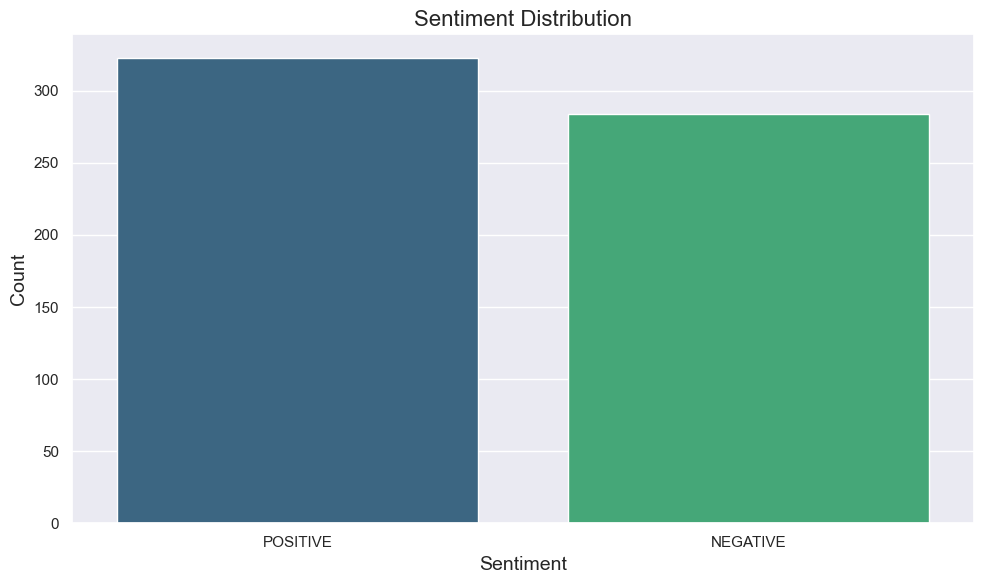

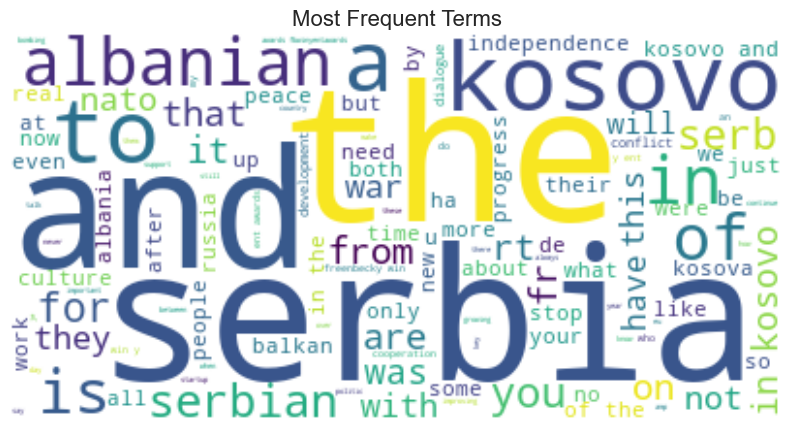

Step 6: Evaluating Model
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        88
           1       0.83      0.79      0.81        95

    accuracy                           0.81       183
   macro avg       0.81      0.81      0.81       183
weighted avg       0.81      0.81      0.81       183

Accuracy: 0.8087431693989071
Confusion Matrix:
[[73 15]
 [20 75]]
Analysis exported to output/ethics_bias_analytics.csv


In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from transformers import pipeline
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

class EthicalBiasDetection:
    def __init__(self, tweets_df):
        self.tweets_df = tweets_df

    def _remove_urls_and_special_chars(self, text):
        text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+|#', '', text)  # Remove mentions and hashtags
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Remove non-alphabetic characters
        return text.strip()

    def preprocess_data(self):
        print("Step 1: Preprocessing Data")
        print("Before cleaning:")
        print(f"Shape of data: {self.tweets_df.shape}")
        print(f"Missing values: {self.tweets_df.isnull().sum()}")
        print(f"Duplicated rows: {self.tweets_df.duplicated().sum()}")

        self.tweets_df.dropna(subset=['Tweet'], inplace=True)
        self.tweets_df.drop_duplicates(subset=['Tweet'], inplace=True)

        print("After cleaning:")
        print(f"Shape of data: {self.tweets_df.shape}")
        print(f"Missing values: {self.tweets_df.isnull().sum()}")
        print(f"Duplicated rows: {self.tweets_df.duplicated().sum()}")

        sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert/distilbert-base-uncased-finetuned-sst-2-english')
        self.tweets_df['sentiment'] = self.tweets_df['Tweet'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
        print("Sentiment analysis completed.")

        self.tweets_df['clean_text'] = self.tweets_df['Tweet'].apply(self._remove_urls_and_special_chars)
        print("Text cleaning completed.")

    def detect_bias(self):
        print("Step 2: Detecting Bias")
        if 'clean_text' not in self.tweets_df.columns:
            raise KeyError("The DataFrame must contain a 'clean_text' column.")

        vectorizer = CountVectorizer(stop_words='english')
        term_matrix = vectorizer.fit_transform(self.tweets_df['clean_text'])

        print("Detecting gender bias in pronoun usage...")
        gender_pronouns = {
            'male': ['he', 'his', 'him'],
            'female': ['she', 'her', 'hers'],
            'neutral': ['they', 'their', 'them']
        }

        bias_scores = {}
        for gender, pronouns in gender_pronouns.items():
            pronoun_indices = [vectorizer.vocabulary_.get(p) for p in pronouns if p in vectorizer.vocabulary_]
            pronoun_counts = term_matrix[:, pronoun_indices].sum(axis=1)
            bias_scores[gender] = pronoun_counts.mean()

        print("Bias detected in pronoun usage:")
        print(bias_scores)

        print("Detecting racial bias related to Kosovo and Serbia...")
        racial_terms = {
            'kosovo': ['kosovo', 'albanian', 'albanians'],
            'serbia': ['serbia', 'serbian', 'serbs'],
            'conflict-related': ['ethnic', 'minority', 'majority']
        }

        racial_bias_scores = {}
        for race, terms in racial_terms.items():
            term_indices = [vectorizer.vocabulary_.get(term) for term in terms if term in vectorizer.vocabulary_]
            term_counts = term_matrix[:, term_indices].sum(axis=1)
            racial_bias_scores[race] = term_counts.mean()

        print("Bias detected in racial term usage:")
        print(racial_bias_scores)

        print("Detecting other biases (e.g., political, ideological)...")
        political_terms = ['democrat', 'republican', 'liberal', 'conservative', 'capitalism', 'socialism']
        political_indices = [vectorizer.vocabulary_.get(term) for term in political_terms if term in vectorizer.vocabulary_]
        political_counts = term_matrix[:, political_indices].sum(axis=1)
        political_bias_score = political_counts.mean()

        print(f"Detected political/ideological bias score: {political_bias_score}")

    def quantify_bias(self):
        print("Step 3: Quantifying Bias")
        if 'conflict_count' not in self.tweets_df.columns:
            conflict_keywords = ['war', 'violence', 'conflict', 'battle', 'fight', 'struggle', 'invaded', 'killed']
            print("Counting conflict-related terms in tweets...")
            self.tweets_df['conflict_count'] = self.tweets_df['Tweet'].apply(lambda x: sum(x.lower().count(word) for word in conflict_keywords) if isinstance(x, str) else 0)

        if 'peace_count' not in self.tweets_df.columns:
            peace_keywords = ['peace', 'harmony', 'unity', 'calm', 'serenity', 'non-violence']
            print("Counting peace-related terms in tweets...")
            self.tweets_df['peace_count'] = self.tweets_df['Tweet'].apply(lambda x: sum(x.lower().count(word) for word in peace_keywords) if isinstance(x, str) else 0)

        total_conflict = self.tweets_df['conflict_count'].sum()
        total_peace = self.tweets_df['peace_count'].sum()
        bias_balance = total_conflict / (total_peace + total_conflict) if (total_peace + total_conflict) > 0 else 0

        self.tweets_df['bias_balance'] = bias_balance

        print("Quantified bias balance:")
        print(self.tweets_df[['conflict_count', 'peace_count', 'bias_balance']].head())

    def mitigate_bias(self):
        print("Step 4: Mitigating Bias")
        def neutralize_pronouns(text):
            for pronoun in ['he', 'him', 'his', 'she', 'her', 'hers']:
                text = text.replace(pronoun, 'they')
            return text

        self.tweets_df['neutralized_text'] = self.tweets_df['clean_text'].apply(neutralize_pronouns)

        def neutralize_racial_terms(text):
            replacements = {
                'kosovo': 'region',
                'serbia': 'region',
                'albanian': 'group',
                'serbian': 'group',
                'ethnic': 'community'
            }
            for term, replacement in replacements.items():
                text = re.sub(rf'\b{term}\b', replacement, text, flags=re.IGNORECASE)
            return text

        self.tweets_df['neutralized_text'] = self.tweets_df['neutralized_text'].apply(neutralize_racial_terms)
        print("Mitigated gender and racial biases in text content.")

    def visualize_analysis(self):
        print("Step 5: Visualizing Analysis")
        sns.set_theme(style="darkgrid")
    
        # 1. Gender Bias Visualization (already included)
        gender_data = {'Gender': ['Male', 'Female', 'Neutral'], 'Bias': [self.tweets_df['clean_text'].str.contains(r'\bhe\b|\bhim\b|\bhis\b').sum(),
                                                                          self.tweets_df['clean_text'].str.contains(r'\bshe\b|\bher\b|\bhers\b').sum(),
                                                                          self.tweets_df['clean_text'].str.contains(r'\bthey\b|\btheir\b|\bthem\b').sum()]}
        gender_df = pd.DataFrame(gender_data)
    
        plt.figure(figsize=(8, 6))
        sns.barplot(data=gender_df, x='Gender', y='Bias', palette='pastel')
        plt.title('Gender Bias Analysis (Pronouns)', fontsize=16)
        plt.xlabel('Gender Pronoun', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # 2. Racial Term Usage Visualization
        print("Visualizing racial term usage frequency...")
        racial_terms = ['kosovo', 'serbia', 'albanian', 'serbian']
        racial_counts = self.tweets_df['clean_text'].str.split().explode().value_counts()
        racial_data = {term: racial_counts.get(term, 0) for term in racial_terms}
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(racial_data.keys()), y=list(racial_data.values()), palette='pastel')
        plt.title('Racial Term Frequency', fontsize=16)
        plt.xlabel('Terms', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.tight_layout()
        plt.show()
    
        # 3. Conflict vs Peace Balance Visualization
        print("Visualizing conflict vs peace balance distribution...")
        plt.figure(figsize=(12, 6))
        sns.histplot(self.tweets_df['bias_balance'], bins=20, kde=True, color='skyblue', edgecolor='black')
        plt.title('Conflict vs Peace Balance Distribution', fontsize=16)
        plt.xlabel('Bias Balance', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.tight_layout()
        plt.show()
    
        # 4. Sentiment Distribution Visualization
        print("Visualizing sentiment distribution...")
        plt.figure(figsize=(10, 6))
        sns.countplot(data=self.tweets_df, x='sentiment', order=['POSITIVE', 'NEGATIVE'], palette='viridis')
        plt.title('Sentiment Distribution', fontsize=16)
        plt.xlabel('Sentiment', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 5. Word Cloud of Most Frequent Terms
        wordcloud = WordCloud(stopwords='english', background_color='white').generate(' '.join(self.tweets_df['clean_text']))
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Most Frequent Terms', fontsize=16)
        plt.show()


    def evaluation_model(self):
        print("Step 6: Evaluating Model")
        if 'neutralized_text' not in self.tweets_df.columns:
            raise KeyError("The DataFrame must contain a 'neutralized_text' column.")

        X = self.tweets_df['neutralized_text']
        y = self.tweets_df['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)  # Binary sentiment: 1 for positive, 0 for negative

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        vectorizer = CountVectorizer(stop_words='english')
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

        model = LogisticRegression()
        model.fit(X_train_resampled, y_train_resampled)

        y_pred = model.predict(X_test_vec)

        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    
    def export_analysis(self, output_path):
        if not self.tweets_df.empty:
            self.tweets_df.to_csv(output_path, index=False)
            print(f"Analysis exported to {output_path}")
        else:
            print("No data to export.")

# Usage
if __name__ == '__main__':
    # Assuming `tweets_df` is a DataFrame with 'Tweet' column and other necessary columns
    tweets_df = pd.read_csv('dataset/tweets.csv')
    ethical_bias_detector = EthicalBiasDetection(tweets_df)

    ethical_bias_detector.preprocess_data()
    ethical_bias_detector.detect_bias()
    ethical_bias_detector.quantify_bias()
    ethical_bias_detector.mitigate_bias()
    ethical_bias_detector.visualize_analysis()
    ethical_bias_detector.evaluation_model()
    ethical_bias_detector.export_analysis('output/ethics_bias_analytics.csv')
